# 5.1 Criação de Modelos de Machine Learning - Tunning

## Carregar dados tratados

In [3]:
# ! pip install seaborn
# ! pip install plotly
# ! pip install statsmodels
# ! pip install sklearn

In [4]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split


from sklearn.metrics import classification_report, confusion_matrix, recall_score

from sklearn.ensemble import GradientBoostingClassifier

from sklearn.model_selection import RandomizedSearchCV

import joblib

In [5]:
def carregar_joblib(file_name: str = "../out/result_analise_desc.joblib"):
    df = joblib.load(file_name)
    return df

In [6]:
def plot_confusion_matrix_heat(cf_matrix):
    cf_matrix.index.name = 'Atual'
    cf_matrix.columns.name = 'Predito'
    
    cf_nd_array = cf_matrix.to_numpy()
    cf_flatten = cf_nd_array.flatten()

    group_names = ["TN", "FP", "FN", "TP"]
    group_counts = ["{0:0.0f}".format(value) for value in
                    cf_flatten]
    group_percentages = ["{0:.2%}".format(value) for value in
                         cf_flatten / np.sum(cf_nd_array)]
    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
              zip(group_names, group_counts, group_percentages)]
    labels = np.asarray(labels).reshape(2, 2)
    print(cf_matrix.shape)
    sns.heatmap(cf_matrix, annot=labels, fmt="", cmap='Blues')


In [7]:
def avaliar(y_teste, y_prev, nome_modelo):
    print(nome_modelo)
    print("Reporte teste")
    report = classification_report(y_teste, y_prev, target_names=["Vender", "Comprar"])
    print(report)
    cf_matrix = pd.DataFrame(confusion_matrix(y_teste, y_prev), index=["Vender", "Comprar"], columns=["Vender", "Comprar"])
    plot_confusion_matrix_heat(cf_matrix)
    plt.show()
    print("Recall: ", recall_score(y_teste, y_prev))
    print("#" * 50)
    return recall_score(y_teste, y_prev)


# ML modelos

## Modelos a serem testados

- Random Forest
- Gradient Boost
- AdaBoost

In [8]:
def definir_modelos_ml() -> dict:
    return {
        "GradientBoost": {'modelo_base': GradientBoostingClassifier(random_state=42), 'modelo_tunado': None},
        # "GradientBoost": {'modelo_base': GradientBoostingClassifier(random_state=42, n_estimators=1000, min_samples_split=10, max_features='auto', learning_rate=0.01, criterion='squared_error'), 'modelo_tunado': None},
    }

In [9]:
def rodar_imprimir_modelos_ml(modelos, X_treino, X_teste, y_treino, y_teste):
    for nome, modelo in modelos.items():
        modelo = modelo.get('modelo_base')
        modelo.fit(X_treino, y_treino)
        previsoes = modelo.predict(X_teste)
        avaliar(y_teste, previsoes, nome + '_base')
        modelos[nome]['modelo_base'] = modelo
    
    return modelos

# Execucao

(1852, 6)
GradientBoost_base
Reporte teste
              precision    recall  f1-score   support

      Vender       0.55      0.45      0.49       242
     Comprar       0.49      0.59      0.54       221

    accuracy                           0.52       463
   macro avg       0.52      0.52      0.52       463
weighted avg       0.52      0.52      0.51       463

(2, 2)


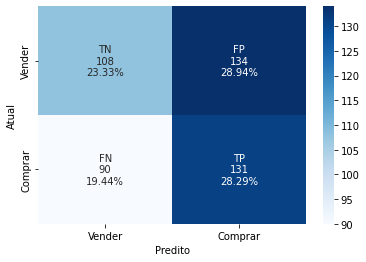

Recall:  0.5927601809954751
##################################################


In [10]:
def main():

    df = carregar_joblib()

    print(df.shape)

    # split database train and test
    X = df.drop(["decisao"], axis=1)
    y = df["decisao"]

    X_treino, X_teste, y_treino, y_teste = train_test_split(X, y, test_size=0.25, random_state=2)

    modelos = definir_modelos_ml()

    modelos = rodar_imprimir_modelos_ml(modelos, X_treino, X_teste, y_treino, y_teste)

    return df, modelos

df, modelos = main()

## Tunning dos 3 melhores modelos

In [11]:
def fit_tunning_rand_search_gradient(X_treino, y_treino):
    print("Tunning randomized search Gradient Boost")

    # Create the random grid
    params = {'n_estimators': [800, 900, 1000],
              'learning_rate': [0.01, 0.015, 0.009],
              'max_features': ['auto', 'sqrt'],
              'min_samples_split': [2, 5, 10],
              'criterion': ["friedman_mse", "squared_error"]}

    print(params)

    rf_random = RandomizedSearchCV(estimator=GradientBoostingClassifier(),
                                   param_distributions=params,
                                   cv=3,
                                   verbose=0,
                                   scoring="recall",
                                   random_state=42,
                                   n_jobs=-1)

    # Fit the random search model
    return rf_random.fit(X_treino, y_treino)

In [12]:

def run_gradient_boost_tunning(df):


    X = df.drop(["decisao"], axis=1)
    y = df["decisao"]

    X_treino, X_teste, y_treino, y_teste = train_test_split(X, y, test_size=0.25, random_state=2)

    resultado_grid = fit_tunning_rand_search_gradient(X_treino, y_treino)

    print("Ajuste Gradient Boost feito")

    print("Best params", resultado_grid.best_params_)
    print("Best score", resultado_grid.best_score_)

    modelo_tunado = resultado_grid.best_estimator_

    return modelo_tunado

In [13]:
def run_tunning_fit(df, modelos):
    '''
        Executa os tunnings com randomized search cv e armazena o modelo tunado
    '''
    modelos['GradientBoost']['modelo_tunado'] = run_gradient_boost_tunning(df)

    return modelos


In [14]:
def compare_tunning(df, modelos: dict):

    X = df.drop(["decisao"], axis=1)
    y = df["decisao"]

    _, X_teste, _, y_teste = train_test_split(X, y, test_size=0.25, random_state=2)

    recalls = {}
    for nome, modelos_dict in modelos.items():
        prev = modelos_dict['modelo_base'].predict(X_teste)
        recalls[nome + '_base'] =  avaliar(y_teste, prev, nome + '_base')
        prev = modelos_dict['modelo_tunado'].predict(X_teste)
        recalls[nome + '_tunned'] = avaliar(y_teste, prev, nome + '_tunado')
    
    # barplot comparacao 3 modelos tunados
    sns.set_theme(style="whitegrid")
    ax = sns.barplot(x=list(recalls.keys()), y=list(recalls.values()))
    ax.set(xlabel="Modelos", ylabel="Recall", title="Recall por Modelo")
    
    

Tunning randomized search Gradient Boost
{'n_estimators': [800, 900, 1000], 'learning_rate': [0.01, 0.015, 0.009], 'max_features': ['auto', 'sqrt'], 'min_samples_split': [2, 5, 10], 'criterion': ['friedman_mse', 'squared_error']}
Ajuste Gradient Boost feito
Best params {'n_estimators': 800, 'min_samples_split': 2, 'max_features': 'sqrt', 'learning_rate': 0.009, 'criterion': 'friedman_mse'}
Best score 0.6370056497175142
GradientBoost_base
Reporte teste
              precision    recall  f1-score   support

      Vender       0.55      0.45      0.49       242
     Comprar       0.49      0.59      0.54       221

    accuracy                           0.52       463
   macro avg       0.52      0.52      0.52       463
weighted avg       0.52      0.52      0.51       463

(2, 2)


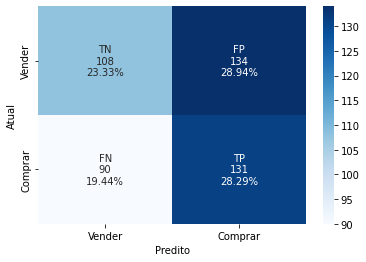

Recall:  0.5927601809954751
##################################################
GradientBoost_tunado
Reporte teste
              precision    recall  f1-score   support

      Vender       0.57      0.40      0.47       242
     Comprar       0.51      0.67      0.58       221

    accuracy                           0.53       463
   macro avg       0.54      0.54      0.53       463
weighted avg       0.54      0.53      0.52       463

(2, 2)


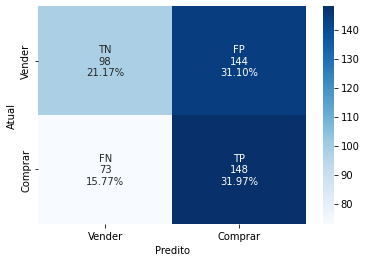

Recall:  0.669683257918552
##################################################


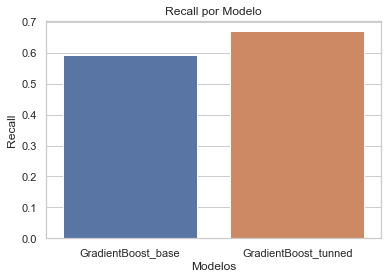

In [15]:
modelos = run_tunning_fit(df, modelos)

compare_tunning(df, modelos)

# Melhor modelo escolhido:

- x

Best score de x%